In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, glob
from tqdm import tqdm

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
from sklearn.manifold import TSNE
import re

/Users/thkill/teaching/sdss_galaxy_unsupervised/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def load_image_from_path(path):
    """
    Decode a jpg image from the string filepath

    :param path: Path to image
    :return: 3D image tensor
    """
    raw_img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(raw_img, channels=3)
    img = tf.image.convert_image_dtype(img, 'float32') # pre-normalises to 0,1

    return img.numpy()

In [3]:
model = tf.keras.models.load_model("autoenc_final_codedim20.h5")
model.summary()

/Users/thkill/teaching/sdss_galaxy_unsupervised/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Kernel shape must have the same length as input, but received kernel of shape (3, 3, 3, 64) and input of shape (None, None, 64, 64, 3).

In [67]:
filepaths = glob.glob("final_64x64_proc/VAL/*.jpg")

In [68]:
imgs = np.array([load_image_from_path(r) for r in tqdm(filepaths)])

100%|██████████| 1539/1539 [00:00<00:00, 4165.51it/s]


In [69]:
# This could take a while without GPU.
reconst = model.predict(imgs, verbose=1, batch_size=128)

13/13 [==============================] - 4s 343ms/step


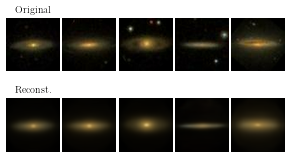

In [70]:
# plot some inputs and their reconstructions.
N_PANELS = 5
fig, ax = plt.subplots(2, N_PANELS, dpi=60)
plt.subplots_adjust(wspace=0.05, hspace=-0.2)

for i, idx in enumerate(np.random.randint(0, len(imgs), N_PANELS)):
    for j, arr in enumerate([imgs, reconst]):
        ax[j][i].imshow(arr[idx], interpolation='lanczos')
        ax[j][i].axis("off")

ax[0][0].set_title("Original")
ax[1][0].set_title("Reconst.")
plt.savefig("written_synopsis_source/reconstructed_valset.pdf", bbox_inches='tight')

In [71]:
# Compute the latent encodings from the autoencoder for the first 1024 stamps.
eval_model = tf.keras.backend.function([model.layers[0].input], [model.layers[16].output])
testvecs = np.array(eval_model(imgs)).reshape(len(imgs), 20)

### Nearest-neighbour sanity check
* Given a chosen image, do the nearest neighbours in latent space look similar? The answer should be yes, but worth checking before we proceed.

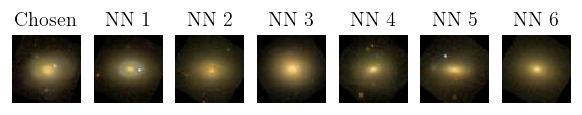

In [72]:
chosen_idx = 42
N_NEAREST_NEIGHBOURS = 6

fig, ax = plt.subplots(1, N_NEAREST_NEIGHBOURS+1, dpi=120)
ax[0].imshow(imgs[chosen_idx])
ax[0].axis("off")
ax[0].set_title("Chosen")

# find N nearest neighbours in latent space according to Euclidean distance.
nn_idxs = np.argsort(np.linalg.norm(testvecs[chosen_idx] - testvecs, axis=1))[1:N_NEAREST_NEIGHBOURS+1]

for i, nn_idx in enumerate(nn_idxs):
    ax[i+1].imshow(imgs[nn_idx])
    ax[i+1].axis("off")
    ax[i+1].set_title("NN {}".format(i+1))

plt.show()

### Unsupervised clustering
* Can we group galaxies based on their latent vectors? 
* Try two clustering methods, both don't require a set number of clusters. What sub-groupings can we find in the data?

In [73]:
from sklearn.cluster import DBSCAN, OPTICS
clusterer = DBSCAN(min_samples=5).fit(testvecs)

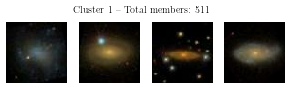

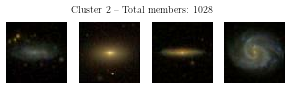

In [74]:
N_EXAMPLES_PER_CLUSTER = 4

for n in np.unique(clusterer.labels_):
    members = np.argwhere(clusterer.labels_ == n).flatten()
    
    fig, ax = plt.subplots(1, N_EXAMPLES_PER_CLUSTER, dpi=60)
    fig.suptitle("Cluster {} -- Total members: {}".format(n+2, len(members)), y=0.7)
    for i, idx in enumerate(np.random.choice(members.flatten(), N_EXAMPLES_PER_CLUSTER, replace=False)):
        ax[i].imshow(imgs[idx])
        ax[i].axis("off")

In [75]:
clusterer = OPTICS(min_samples=5).fit(testvecs)

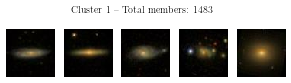

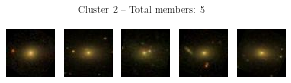

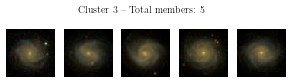

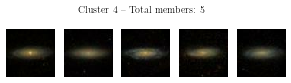

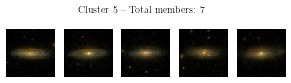

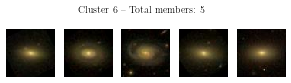

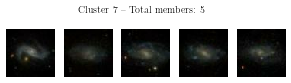

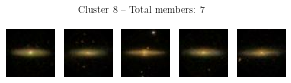

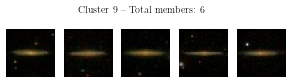

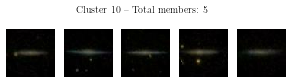

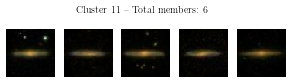

In [76]:
N_EXAMPLES_PER_CLUSTER = 5

for n in np.unique(clusterer.labels_):
    members = np.argwhere(clusterer.labels_ == n).flatten()
    
    fig, ax = plt.subplots(1, N_EXAMPLES_PER_CLUSTER, dpi=60)
    fig.suptitle("Cluster {} -- Total members: {}".format(n+2, len(members)), y=0.7)
    for i, idx in enumerate(np.random.choice(members.flatten(), N_EXAMPLES_PER_CLUSTER, replace=False)):
        ax[i].imshow(imgs[idx])
        ax[i].axis("off")

plt.show()

### The problem
* End up in the regime with one large cluster, and many smaller clusters. If we set the minimum number of clusters too low, we end up with unrepresentative clusters.
* Solution: hierarchical clustering. This essentially builds clusters from the bottom up, with clusters being merged if a certain metric (here Ward linkage) is met. This means that clusters do not end up with such disparate sizes.

In [77]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [97]:
connectivity_matr = kneighbors_graph(testvecs, n_neighbors=4, mode='connectivity')
clusterer = AgglomerativeClustering(n_clusters=5, connectivity=connectivity_matr).fit(testvecs)

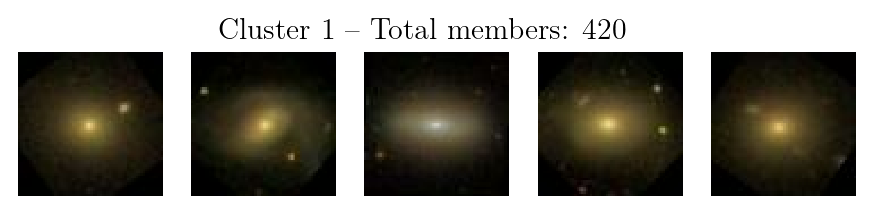

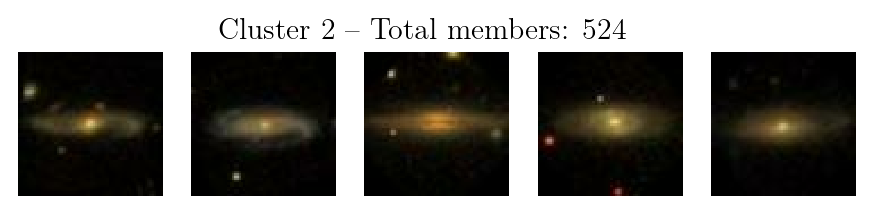

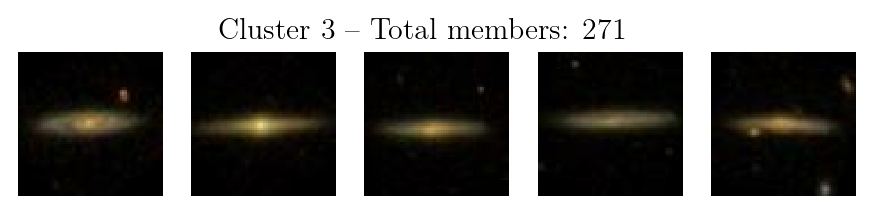

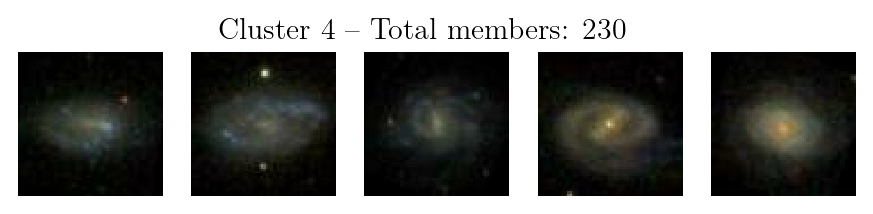

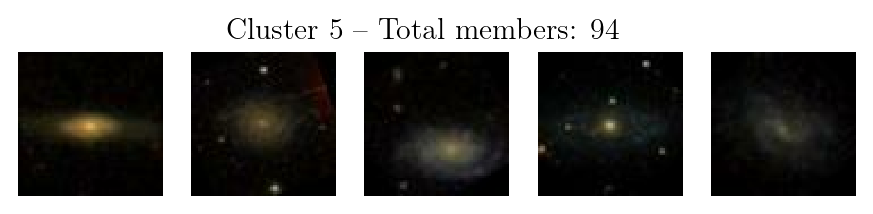

In [98]:
N_EXAMPLES_PER_CLUSTER = 5
for n in np.unique(clusterer.labels_):
    members = np.argwhere(clusterer.labels_ == n).flatten()
    
    fig, ax = plt.subplots(1, N_EXAMPLES_PER_CLUSTER, dpi=180)
    fig.suptitle("Cluster {} -- Total members: {}".format(n+1, len(members)), y=0.65)
    for i, idx in enumerate(np.random.choice(members.flatten(), N_EXAMPLES_PER_CLUSTER, replace=False)):
        ax[i].imshow(imgs[idx])
        ax[i].axis("off")

    fig.savefig("written_synopsis_source/clusters_hierarchical{}.png".format(n), bbox_inches='tight')

### Does our clustering map in any way to morphology?
* Let's take the galaxies with morphological information, strip away the subtypes and make some broad classes. 
  * E: ellipticals
  * SB: barred spirals
  * S: regular spirals
  * Irr: irregulars -- not any of the above


In [82]:
morphology = np.array([f.split("/")[-1][:-4].split("_")[-1] for f in filepaths])

def amend_morphology_str(morphstr):
    # Merge all ellipticals into one class
    if re.search("E.", morphstr):
        return "E"
    
    # Merge all barred spirals into one class
    if re.search("SB.", morphstr):
        return "SB"
    
    # Move transitional spirals into Irregular
    if re.search("Sm", morphstr):
        return "Irr"
    
    # All spirals in the same class
    if re.search("S.", morphstr):
        return "S"
    
    else:
        return morphstr
    
morphology_corr = np.array([amend_morphology_str(s) for s in morphology])

E: 55 of 1539
Irr: 29 of 1539
NA: 784 of 1539
S: 544 of 1539
SB: 127 of 1539


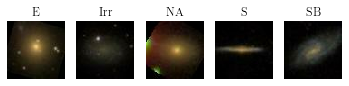

In [83]:
for m in np.unique(morphology_corr):
    print("{}: {} of {}".format(m, (morphology_corr == m).sum(), len(morphology_corr)))
    
fig, ax = plt.subplots(1, len(np.unique(morphology_corr)))

print("Example morphology classes")
for i, m in enumerate(np.unique(morphology_corr)):
    idx = np.random.choice(np.argwhere(morphology_corr == m).flatten())
    ax[i].imshow(imgs[idx])
    ax[i].set_title(m)
    ax[i].axis("off")

In [99]:
for c in np.unique(clusterer.labels_):
    mask1 = (clusterer.labels_ == c) 
    mask2 = mask1 & (morphology_corr != "NA")
    print("Cluster {}: {} of {}".format(c+1, mask2.sum(), mask1.sum()))
    for m in np.unique(morphology_corr):
        morph_mask = morphology_corr[mask2] == m
        print("{:.1f} % of all {}".format(100*morph_mask.sum() / (morphology_corr == m).sum(), m))
        

Cluster 1: 171 of 420
87.3 % of all E
6.9 % of all Irr
0.0 % of all NA
17.6 % of all S
19.7 % of all SB
Cluster 2: 251 of 524
9.1 % of all E
13.8 % of all Irr
0.0 % of all NA
37.9 % of all S
28.3 % of all SB
Cluster 3: 129 of 271
0.0 % of all E
3.4 % of all Irr
0.0 % of all NA
22.8 % of all S
3.1 % of all SB
Cluster 4: 169 of 230
3.6 % of all E
41.4 % of all Irr
0.0 % of all NA
18.4 % of all S
43.3 % of all SB
Cluster 5: 35 of 94
0.0 % of all E
34.5 % of all Irr
0.0 % of all NA
3.3 % of all S
5.5 % of all SB


### Answer: kind of, but not really.
* See that cluster 1 contains 80% of all ellipticals.
* 45% of all irregulars in cluster 2
* Spirals scattered across all clusters.

* (True) galaxy morphology is not a function of viewing angle, which is the one remaining parameter I haven't been able to remove from this. 

### t-SNE
* Let's apply t-stochastic neighbour embedding to reduce the dimensionality of the latent vectors. How well can we split the classes in this view?

In [85]:
tsne_vecs = TSNE(perplexity=200, n_jobs=-1, verbose=1).fit_transform(testvecs)

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 1539 samples in 0.005s...
[t-SNE] Computed neighbors for 1539 samples in 0.192s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1539
[t-SNE] Computed conditional probabilities for sample 1539 / 1539
[t-SNE] Mean sigma: 0.494765
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.853397
[t-SNE] KL divergence after 850 iterations: 0.607959


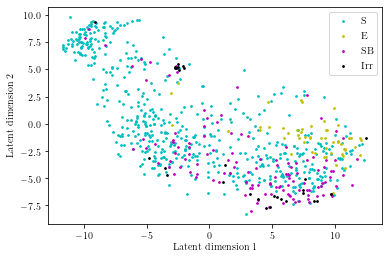

In [90]:
classes = ["S", "E", "SB", "Irr"]
colors = ["c", "y", "m", "k"]
for c, col in zip(classes, colors):
    mask = morphology_corr == c
    plt.scatter(tsne_vecs[mask,0], tsne_vecs[mask,1], s=3, c=col, label=c)
plt.xlabel("Latent dimension 1")
plt.ylabel("Latent dimension 2")
plt.legend()
plt.savefig("written_synopsis_source/tsne_splitting.png", bbox_inches='tight')

### How did we do?
* There is a clear splitting between ellipticals and spirals.
* Splitting barred and unbarred spirals much harder - maybe this is a resolution issue?
* Irregulars broadly lie on the edge of the point cloud -- they are irregular!

##### Despite the not exceptional performance, let's explore some clustering metrics

In [93]:
# convert 
morph_labels = morphology_corr[morphology_corr != "NA"]
morph_labels[morph_labels == "E"] = 0
morph_labels[morph_labels == "S"] = 1
morph_labels[morph_labels == "SB"] = 2
morph_labels[morph_labels == "Irr"] = 3
clust_labels = clusterer.labels_[morphology_corr != "NA"]

In [94]:
from sklearn import metrics

In [103]:
print("Silhouette score: {:.3f}".format(metrics.silhouette_score(testvecs, clusterer.labels_)))
print("Mutual information score: {:.3f}".format(metrics.mutual_info_score(morph_labels, clust_labels)))

Silhouette score: 0.152
Mutual information score: 0.226
